# Análisis comparativo de tarifas móviles - Megaline

En este proyecto se realizará un análisis exploratorio de datos de la empresa de telecomunicaciones Megaline, enfocándose en la comparación de dos planes prepago: Surf y Ultimate. El objetivo principal es identificar cuál de estas tarifas genera mayores ingresos, lo cual permitirá orientar decisiones estratégicas relacionadas con la asignación del presupuesto publicitario.

Se utilizará una muestra representativa de 500 clientes, para la cual se dispone de información relevante como el perfil del usuario, su ubicación geográfica, la tarifa contratada, así como el uso mensual de llamadas y mensajes de texto durante el año 2018. A partir de estos datos, se trazará un análisis detallado del comportamiento de los usuarios según el plan, se visualizarán las tendencias de consumo y se calcularán los ingresos generados por cada cliente. Esto permitirá establecer conclusiones claras sobre la rentabilidad de cada tarifa.



## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as st



## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv("/datasets/megaline_calls.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
users = pd.read_csv("/datasets/megaline_users.csv")


## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
dataframes = {
    "calls": calls,
    "messages": messages,
    "internet": internet,
    "plans": plans,
    "users": users
}
for name, df in dataframes.items():
    print(f"\nInformación del DataFrame: {name}")
    print(df.info())
    print(df.head())
    print("-" * 50)



Información del DataFrame: calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
--------------------------------------------------

Información del DataFrame: messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   

In [4]:
# Imprime una muestra de los datos para las tarifas
print("\nInformación general de planes:")
print(plans.info())
print("\nMuestra de datos de planes:")
print(plans.head())



Información general de planes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None

Muestra de datos de planes:
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  us

# Revisión y transformación inicial de los datos

Antes de proceder con el análisis, se realizará una revisión del tipo de datos y de la consistencia en cada uno de los DataFrames:

En calls, la columna call_date se encuentra en formato object, por lo que se convertirá al tipo de dato datetime. Además, la columna duration contiene valores decimales, pero dado que la facturación se realiza por minutos completos, se redondeará cada valor hacia arriba al entero más próximo.

En messages, la columna message_date también está en formato object y se convertirá al tipo datetime para facilitar el análisis temporal.

En internet, la columna session_date será igualmente transformada al formato datetime, ya que actualmente se encuentra como object.

En plans, no se han identificado valores nulos y todas las columnas presentan tipos de datos correctos (int64, float64, object), por lo que no se requieren transformaciones en esta tabla.

En users, tanto reg_date como churn_date están en formato object y deben ser convertidas a datetime. La columna churn_date contiene valores nulos correspondientes a clientes que aún mantienen el servicio activo. Estos valores no deben eliminarse, sino conservarse como indicador de clientes vigentes.

Acciones a ejecutar:

Se convertirán las columnas de fecha (call_date, message_date, session_date, reg_date, churn_date) al formato datetime en todos los DataFrames correspondientes.

Se redondeará la duración de las llamadas hacia arriba para reflejar la política de facturación por minutos enteros.

Se conservarán los valores nulos en churn_date como señal de clientes activos, sin imputación adicional.

## Corregir datos

In [5]:
# Convertir columnas de fecha a tipo datetime
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

# Redondear duración de llamadas hacia arriba
calls['duration'] = np.ceil(calls['duration']).astype(int)

## Enriquecer los datos

In [6]:
# Extraer el mes y año de cada fecha para facilitar el análisis mensual
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month
users['reg_month'] = users['reg_date'].dt.month

# Convertir los megabytes consumidos en gigabytes y redondear hacia arriba (según las reglas de Megaline)
internet['gb_used'] = np.ceil(internet['mb_used'] / 1024).astype(int)

## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
print("\nInformación general del DataFrame de usuarios:")
print(users.info())



Información general del DataFrame de usuarios:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
 8   reg_month   500 non-null    int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 35.3+ KB
None


In [8]:
# Imprime una muestra de datos para usuarios
print("\nMuestra de datos del DataFrame de usuarios:")
print(users.head())



Muestra de datos del DataFrame de usuarios:
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

    reg_date      plan churn_date  reg_month  
0 2018-12-24  ultimate        NaT         12  
1 2018-08-13      surf        NaT          8  
2 2018-10-21      surf        NaT         10  
3 2018-01-28      surf        NaT          1  
4 2018-05-23      surf        NaT          5  


Tipos de Datos Correctos:
user_id, age, y reg_month son de tipo int64, lo cual es correcto.
reg_date y churn_date están correctamente convertidos a datetime64, lo que facilita el análisis de fechas.
first_name, last_name, city y plan son object, lo cual es adecuado.

Valores Nulos:
La columna churn_date tiene 34 valores no nulos de 500, lo que significa que la mayoría de los clientes aún siguen activos.
NaT en churn_date es esperable y no debe corregirse.
Columna reg_month Se ha agregado correctamente y representa el mes de registro del usuario.

Posibles Mejoras
Mantener churn_date con valores nulos sin modificación.
No es necesario eliminar ni rellenar estos valores, ya que indican clientes activos.
En el contexto de churn_date, significa que esos clientes todavía están activos y no han cancelado su servicio. Solo 34 de los 500 usuarios tienen una fecha de cancelación, lo que indica que 466 clientes aún usan la tarifa.

Conclusión

No hay problemas críticos en los datos de usuarios.
No se necesitan cambios adicionales.
Los datos están listos para el análisis.


### Corregir los datos

No hay problemas críticos en los datos de usuarios

### Enriquecer los datos

No se necesitan cambios adicionales

## Llamadas

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
print("\nInformación general del DataFrame de llamadas:")
print(calls.info())



Información general del DataFrame de llamadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB
None


In [12]:
# Imprime una muestra de datos para las llamadas
print("\nMuestra de datos del DataFrame de llamadas:")
print(calls.head())



Muestra de datos del DataFrame de llamadas:
         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12


Tipos de Datos Correctos:

id es de tipo object, lo cual es adecuado ya que es un identificador único de cada llamada.
user_id es de tipo int64, correcto para identificar a cada usuario.
call_date está en formato datetime64, lo cual es ideal para análisis temporales.
duration ha sido redondeado correctamente a un número entero (int64), según la política de Megaline de cobrar por minutos completos.
month es un número entero (int64), útil para análisis mensuales.

Valores Nulos: No hay valores nulos en ninguna columna, lo que indica que la información de llamadas está completa.

Corrección Aplicada:

Se aplicó correctamente el redondeo de duración de llamadas hacia arriba.
Se extrajo el mes de call_date y se almacenó en la columna month, lo cual facilitará el análisis mensual.

Conclusiones: 
No se detectan problemas en los datos.
No se necesitan cambios adicionales.
Datos listos para el análisis. 

### Corregir los datos

Se aplicó correctamente el redondeo de duración de llamadas hacia arriba.

### Enriquecer los datos

Se extrajo el mes de call_date y se almacenó en la columna month, lo cual facilitará el análisis mensual.

## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
print("\nInformación general del DataFrame de mensajes:")
print(messages.info())



Información general del DataFrame de mensajes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB
None


In [16]:
# Imprime una muestra de datos para los mensajes
print("\nMuestra de datos del DataFrame de mensajes:")
print(messages.head())



Muestra de datos del DataFrame de mensajes:
         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12


Los tipos de datos están correctos.

Valores Nulos: No hay valores nulos en ninguna columna, lo que indica que la información de mensajes está completa.

Corrección Aplicada:
Se convirtió correctamente la columna message_date a datetime64[ns].
Se extrajo el mes de message_date en la columna month, lo cual facilitará el análisis de uso de mensajes por mes.

Posibles Mejoras: No se detectan problemas en los datos. No se necesitan cambios adicionales. Datos listos para el análisis.

### Corregir los datos

No se detectan problemas en los datos. 

### Enriquecer los datos

No se necesitan cambios adicionales.

## Internet

In [19]:
# Imprime la información general/resumida sobre el DataFrame de internet
# Imprimir información general del DataFrame de internet
print("\nInformación general del DataFrame de internet:")
print(internet.info())



Información general del DataFrame de internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
 5   gb_used       104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 4.8+ MB
None


In [20]:
# Imprime una muestra de datos para el tráfico de internet
print("\nMuestra de datos del DataFrame de internet:")
print(internet.head())



Muestra de datos del DataFrame de internet:
         id  user_id session_date  mb_used  month  gb_used
0   1000_13     1000   2018-12-29    89.86     12        1
1  1000_204     1000   2018-12-31     0.00     12        0
2  1000_379     1000   2018-12-28   660.40     12        1
3  1000_413     1000   2018-12-26   270.99     12        1
4  1000_442     1000   2018-12-27   880.22     12        1


Los tipos de datos están correctos: Por ejemplo, month es un número entero (int64), lo que facilitará el análisis mensual y gb_used es un número entero (int64), lo que es útil ya que Megaline cobra por gigabytes enteros.

Valores Nulos: No hay valores nulos en ninguna columna, lo que indica que la información de uso de internet está completa.

Corrección Aplicada: 

Se convirtió correctamente la columna session_date a datetime64[ns].
Se extrajo el mes de session_date en la columna month, lo cual facilitará el análisis del uso de datos por mes.
Se agregó la columna gb_used, calculada como el redondeo hacia arriba de mb_used / 1024, lo cual es necesario para el análisis de facturación.

Posibles mejoras: 
No se detectan problemas en los datos.
No se necesitan cambios adicionales.
Los datos están listos para el análisis.

### Corregir los datos

No se detectan problemas en los datos.  Se corrigieron más arriba.

## Estudiar las condiciones de las tarifas

Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción.

In [23]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print("\nCondiciones de las tarifas:")
print(plans)



Condiciones de las tarifas:
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


## Agregación de datos por usuario y período

Una vez finalizado el proceso de limpieza y transformación de los datos, se procederá a agrupar la información por usuario y por período (mes). Esta consolidación permitirá que cada cliente cuente con un único registro por mes, lo cual facilitará significativamente el análisis comparativo posterior entre tarifas, al reducir la granularidad y optimizar la estructura de los datos para cálculos agregados.

In [24]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_user = calls.groupby(['user_id', 'month'])['id'].count().reset_index()
calls_per_user.rename(columns={'id': 'total_calls'}, inplace=True)


In [25]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_per_user = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
minutes_per_user.rename(columns={'duration': 'total_minutes'}, inplace=True)


In [26]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_per_user = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_per_user.rename(columns={'id': 'total_messages'}, inplace=True)


In [27]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_per_user = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index()
internet_per_user.rename(columns={'gb_used': 'total_gb'}, inplace=True)


Se agregaron los datos por usuario y por periodo.

In [28]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
users_data = users[['user_id', 'city', 'plan']]  # Mantener solo las columnas necesarias de usuarios
df = calls_per_user.merge(minutes_per_user, on=['user_id', 'month'], how='left')
df = df.merge(messages_per_user, on=['user_id', 'month'], how='left')
df = df.merge(internet_per_user, on=['user_id', 'month'], how='left')
df = df.merge(users_data, on='user_id', how='left')

# Rellenar valores NaN con 0 (usuarios que no usaron mensajes o datos en un mes)
df.fillna(0, inplace=True)


In [29]:
# Añade la información de la tarifa
df = df.merge(plans, left_on='plan', right_on='plan_name', how='left')


Se fusiona los datos de llamadas, minutos, mensajes e Internet usando user_id y month.
Se añade la información del plan con un merge en plan.

Para el siguiente cálculo:
Se calcula el uso adicional de minutos, mensajes y gigabytes y aplica los costos extra.
Se calcula el ingreso mensual sumando la tarifa fija y los costos adicionales.
Se mantiene solo las columnas necesarias para el análisis.

In [30]:
# Calcula el ingreso mensual para cada usuario
df['extra_minutes'] = (df['total_minutes'] - df['minutes_included']).clip(lower=0)
df['extra_messages'] = (df['total_messages'] - df['messages_included']).clip(lower=0)
df['extra_gb'] = (df['total_gb'] - (df['mb_per_month_included'] / 1024)).clip(lower=0)

df['income'] = (
    df['usd_monthly_pay'] +
    df['extra_minutes'] * df['usd_per_minute'] +
    df['extra_messages'] * df['usd_per_message'] +
    df['extra_gb'] * df['usd_per_gb']
)

# Seleccionar solo las columnas relevantes
df = df[['user_id', 'month', 'total_calls', 'total_minutes', 'total_messages', 'total_gb', 'plan', 'income']]

# Mostrar los primeros registros
print("\nDatos fusionados con ingresos calculados:")
print(df.head())



Datos fusionados con ingresos calculados:
   user_id  month  total_calls  total_minutes  total_messages  total_gb  \
0     1000     12           16            124            11.0       4.0   
1     1001      8           27            182            30.0      21.0   
2     1001      9           49            315            44.0      41.0   
3     1001     10           65            393            53.0      50.0   
4     1001     11           64            426            36.0      49.0   

       plan  income  
0  ultimate   70.00  
1      surf   80.00  
2      surf  280.00  
3      surf  370.09  
4      surf  360.00  


## Estudia el comportamiento de usuario

Se calcularán estadísticas descriptivas sobre los datos previamente agregados y fusionados, con el objetivo de obtener una visión general del comportamiento de los usuarios. Estas métricas permitirán identificar patrones de uso y diferencias relevantes entre las tarifas Surf y Ultimate.

Asimismo, se visualizarán los resultados mediante gráficos representativos que faciliten la comprensión de los datos y resalten las tendencias clave. Dado que el propósito principal del análisis es determinar cuál de las tarifas genera mayores ingresos, tanto las estadísticas como las visualizaciones se desglosarán por tipo de tarifa.

En el caso de las llamadas, se proporcionan sugerencias específicas en los comentarios del código, pero para los mensajes y el uso de Internet se aplicará el mismo enfoque estadístico, considerando la cantidad de unidades consumidas y su impacto en la facturación total.

### Llamadas

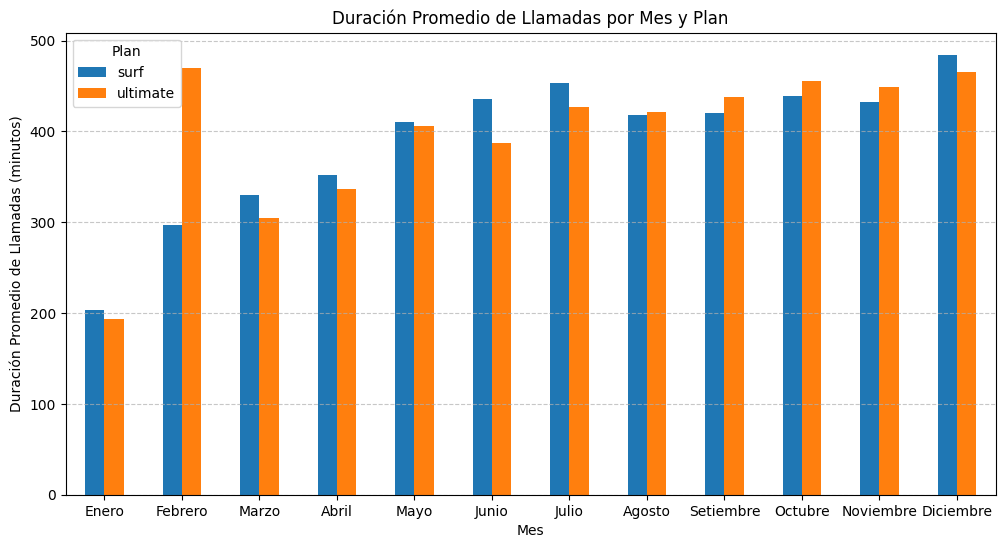

In [31]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
import matplotlib.pyplot as plt

calls_avg_per_plan = df.groupby(['month', 'plan'])['total_minutes'].mean().unstack()
# Gráfico de barras para visualizar la duración promedio de llamadas por plan y mes
calls_avg_per_plan.plot(kind='bar', figsize=(12, 6))
plt.title("Duración Promedio de Llamadas por Mes y Plan")
plt.xlabel("Mes")
plt.ylabel("Duración Promedio de Llamadas (minutos)")
plt.legend(title="Plan")
plt.xticks(rotation=0 , ticks=range(12),  labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio' , 'Agosto', 'Setiembre', 'Octubre', 'Noviembre', 'Diciembre'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


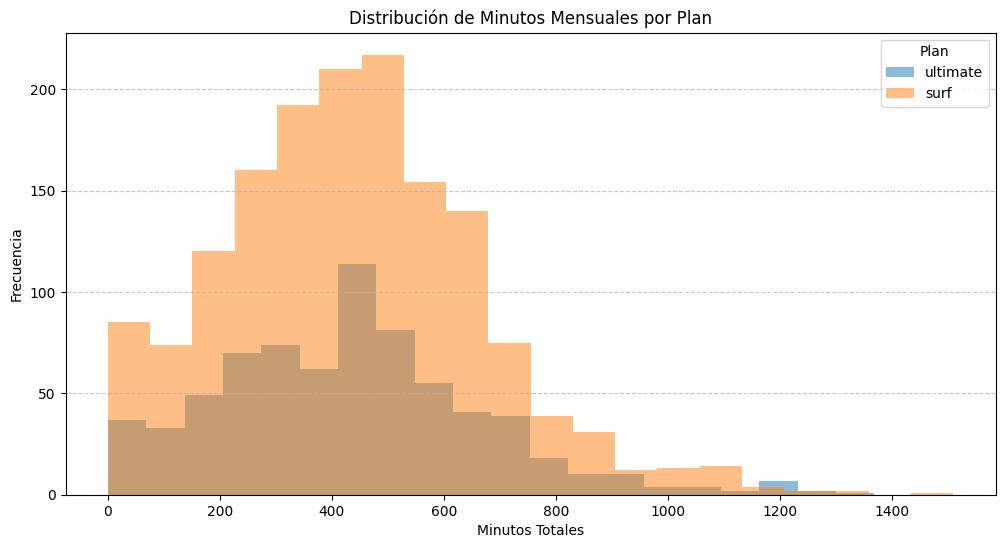

In [32]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
plt.figure(figsize=(12, 6))
for plan in df['plan'].unique():
    subset = df[df['plan'] == plan]['total_minutes']
    plt.hist(subset, bins=20, alpha=0.5, label=plan)

plt.title("Distribución de Minutos Mensuales por Plan")
plt.xlabel("Minutos Totales")
plt.ylabel("Frecuencia")
plt.legend(title="Plan")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Se calculará la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.

In [33]:
# Calcula la media y la varianza de la duración mensual de llamadas.
calls_stats = df.groupby('plan')['total_minutes'].agg(['mean', 'var']).reset_index()


<Figure size 1200x600 with 0 Axes>

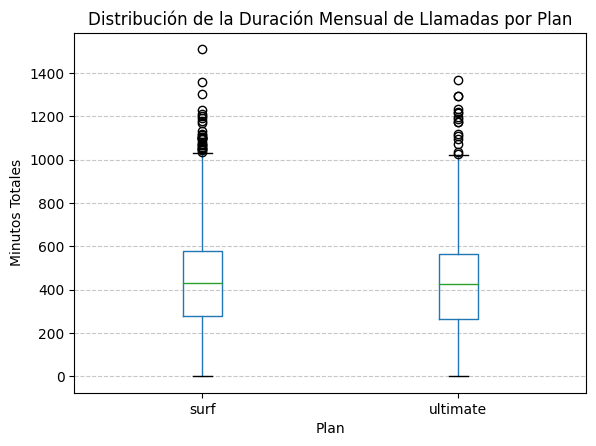

In [34]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.figure(figsize=(12, 6))
df.boxplot(column='total_minutes', by='plan', grid=False)
plt.title("Distribución de la Duración Mensual de Llamadas por Plan")
plt.suptitle("")
plt.xlabel("Plan")
plt.ylabel("Minutos Totales")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#Duración Promedio de Llamadas por Mes y Plan (Gráfico de Barras):
.En general, la duración promedio de llamadas en ambos planes aumenta a lo largo del año.
.No hay una gran diferencia en la duración promedio de llamadas entre los planes Surf y Ultimate.
.En algunos meses, Surf tiene un mayor uso de minutos, y en otros meses, Ultimate supera a Surf. Esto sugiere que no hay una tendencia clara de mayor consumo en un solo plan.

Distribución de Minutos Mensuales por Plan (Histograma):

.La mayoría de los usuarios de Surf y Ultimate usan entre 200 y 600 minutos mensuales.
.Existen algunos usuarios con consumos elevados de minutos, pero son casos aislados.
.La distribución de Surf parece más extendida, lo que indica una mayor variabilidad en el consumo de minutos.

Diagrama de Caja (Boxplot):

.Ambos planes tienen una mediana similar en cuanto a minutos usados por mes.
.Existen valores atípicos en ambos planes, indicando que hay usuarios que realizan un uso excesivo de los minutos disponibles.
.La dispersión de los datos es bastante amplia en ambos planes, lo que significa que hay usuarios con consumos muy distintos dentro de cada grupo.

¿El comportamiento varía en función del plan?
.No hay una diferencia significativa en el uso de minutos entre los planes.
.El uso de minutos es variable dentro de cada plan, con valores atípicos en ambos.
.La cantidad de minutos utilizados no parece ser un factor clave para elegir un plan, ya que ambos grupos tienen comportamientos similares.
.Dado que no hay una gran diferencia en el consumo de minutos, el factor decisivo para elegir un plan puede no ser los minutos, sino los mensajes o datos móviles. Esto lo veremos más adelante.

### Mensajes

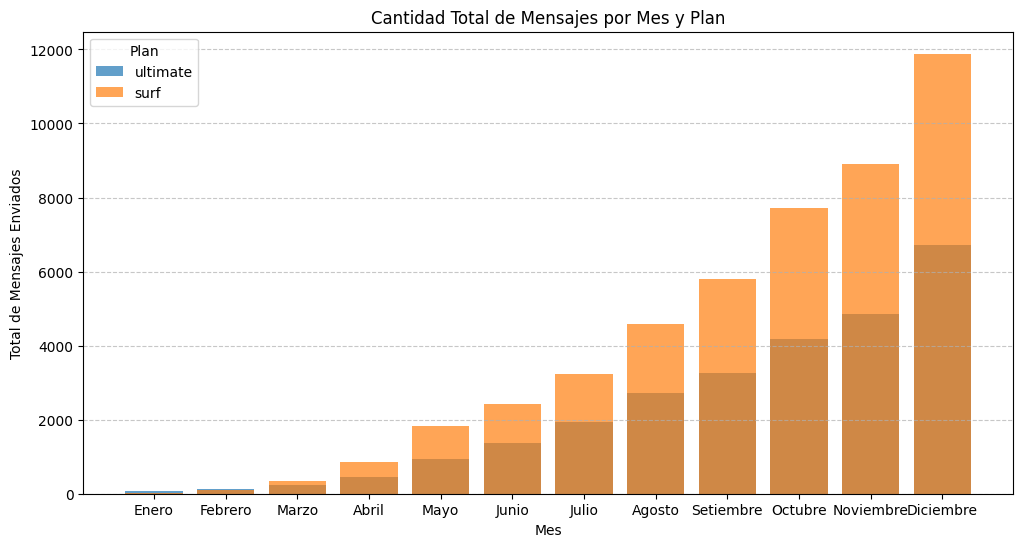

In [35]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
messages_total_per_plan = df.groupby(['month', 'plan'])['total_messages'].sum().reset_index()

# Gráfico de barras para visualizar la cantidad total de mensajes por plan y mes
plt.figure(figsize=(12, 6))
for plan in df['plan'].unique():
    subset = messages_total_per_plan[messages_total_per_plan['plan'] == plan]
    plt.bar(subset['month'], subset['total_messages'], alpha=0.7, label=plan)

plt.title("Cantidad Total de Mensajes por Mes y Plan")
plt.xlabel("Mes")
plt.ylabel("Total de Mensajes Enviados")
plt.legend(title="Plan")
plt.xticks(rotation=0, ticks=range(1,13),  labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio' , 'Agosto', 'Setiembre', 'Octubre', 'Noviembre', 'Diciembre'])  # Asegurar que todos los meses aparecen en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

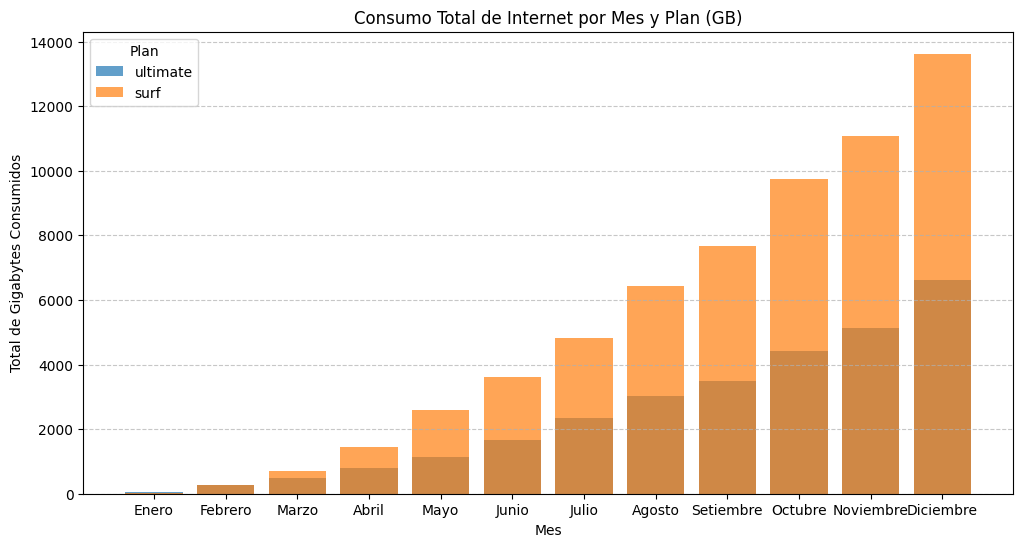

In [36]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_total_per_plan = df.groupby(['month', 'plan'])['total_gb'].sum().reset_index()

# Gráfico de barras para visualizar el consumo total de datos por plan y mes
plt.figure(figsize=(12, 6))
for plan in df['plan'].unique():
    subset = internet_total_per_plan[internet_total_per_plan['plan'] == plan]
    plt.bar(subset['month'], subset['total_gb'], alpha=0.7, label=plan)

plt.title("Consumo Total de Internet por Mes y Plan (GB)")
plt.xlabel("Mes")
plt.ylabel("Total de Gigabytes Consumidos")
plt.legend(title="Plan")
plt.xticks(rotation=0, ticks=range(1,13),  labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio' , 'Agosto', 'Setiembre', 'Octubre', 'Noviembre', 'Diciembre'])  # Asegurar que todos los meses aparecen en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


El número total de mensajes enviados y el consumo total de datos aumenta a lo largo del año, con un pico en diciembre.
Los usuarios de Ultimate envían significativamente más mensajes y consumen más datos que los de Surf.
El comportamiento varía según el plan: los usuarios de Surf envían menos mensajes, probablemente porque pagan por SMS adicionales. Respecto al internet, los usuarios de Surf podrían estar restringidos por su límite más bajo o por costos adicionales.

### Internet

<Figure size 1200x600 with 0 Axes>

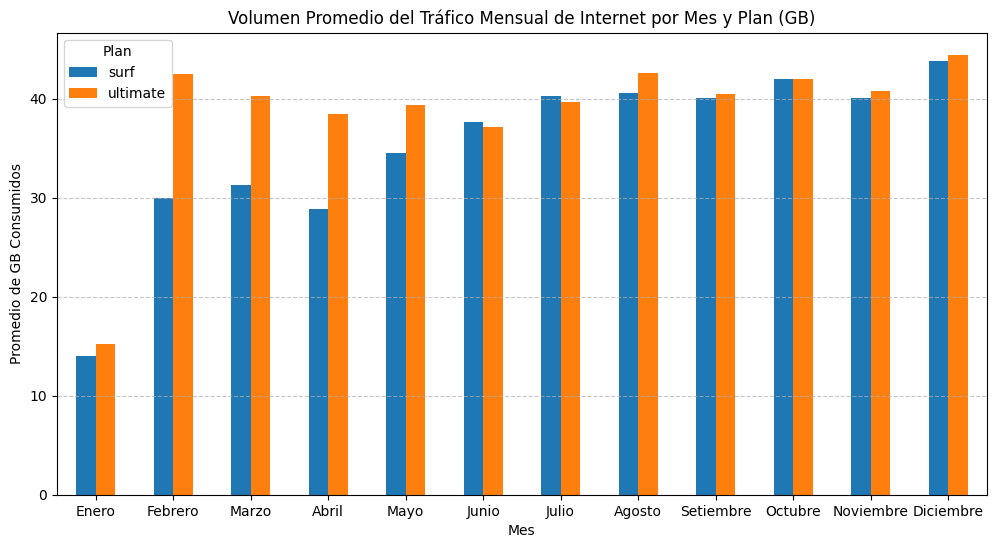

In [37]:
# Comparar la duración promedio del volumen del tráfico mensual de Internet por cada plan y mes
internet_avg_per_plan = df.groupby(['month', 'plan'])['total_gb'].mean().unstack()

# Gráfico de barras para visualizar el volumen promedio del tráfico mensual de Internet por plan y mes
plt.figure(figsize=(12, 6))
internet_avg_per_plan.plot(kind='bar', figsize=(12, 6))
plt.title("Volumen Promedio del Tráfico Mensual de Internet por Mes y Plan (GB)")
plt.xlabel("Mes")
plt.ylabel("Promedio de GB Consumidos")
plt.legend(title="Plan")
plt.xticks(rotation=0, ticks=range(0,12), labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio' , 'Agosto', 'Setiembre', 'Octubre', 'Noviembre', 'Diciembre'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



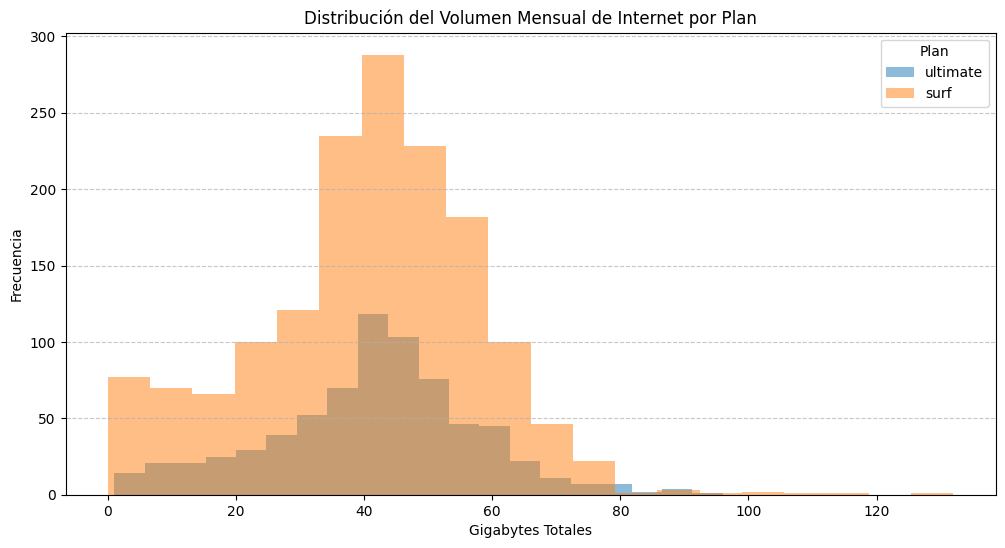

In [38]:
# Comparar el volumen del tráfico mensual de Internet que necesitan los usuarios de cada plan (Histograma)

plt.figure(figsize=(12, 6))
for plan in df['plan'].unique():
    subset = df[df['plan'] == plan]['total_gb']
    plt.hist(subset, bins=20, alpha=0.5, label=plan)

plt.title("Distribución del Volumen Mensual de Internet por Plan")
plt.xlabel("Gigabytes Totales")
plt.ylabel("Frecuencia")
plt.legend(title="Plan")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Figure size 1200x600 with 0 Axes>

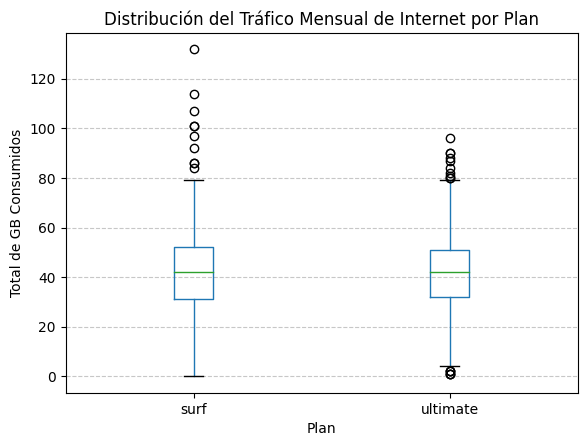

In [39]:
# Calcular la media y la varianza del volumen del tráfico mensual de Internet
internet_stats = df.groupby('plan')['total_gb'].agg(['mean', 'var']).reset_index()

# Traza un diagrama de caja para visualizar la distribución del volumen del tráfico mensual de Internet
plt.figure(figsize=(12, 6))
df.boxplot(column='total_gb', by='plan', grid=False)
plt.title("Distribución del Tráfico Mensual de Internet por Plan")
plt.suptitle("")
plt.xlabel("Plan")
plt.ylabel("Total de GB Consumidos")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Conclusiones sobre el tráfico de Internet:

El consumo promedio de datos es similar entre ambos planes, aunque Ultimate tiene ligeras variaciones en ciertos meses.

La distribución del consumo (histograma) muestra que la mayoría de los usuarios consumen entre 30 y 60 GB al mes.

El boxplot indica que ambos planes tienen valores atípicos, con usuarios que superan ampliamente los límites incluidos.

No hay una diferencia clara en el comportamiento entre los planes; ambos tienen una alta dispersión en el uso de datos.

La media del consumo de datos en ambos planes (según el boxplot) es bastante similar. Esto indica que, en promedio, los usuarios de Surf y Ultimate consumen casi la misma cantidad de GB al mes.

La diferencia clave radica en la dispersión: hay usuarios de ambos planes que superan ampliamente los límites incluidos, generando valores atípicos.

Ultimate no muestra una ventaja clara en términos de menor uso de datos extra, lo que sugiere que los usuarios no eligen este plan solo por su mayor límite de datos.

🔍 Los usuarios de ambos planes usan Internet de manera intensiva, y la oferta de datos debe adaptarse a la demanda creciente. 

🔍 Conclusión: La media del consumo mensual de datos es similar en ambos planes, lo que refuerza la idea de que el plan no influye significativamente en el comportamiento del usuario.


## Ingreso

Se describirá estadísticamente los ingresos de los planes del mismo modo que se ha estudiado el comportamiento de los usuarios.

       plan        mean  median           var         std        sum
0      surf  282.364997   290.0  25960.869119  161.123770  436253.92
1  ultimate  167.018233   154.0   7551.779161   86.900973  119084.00


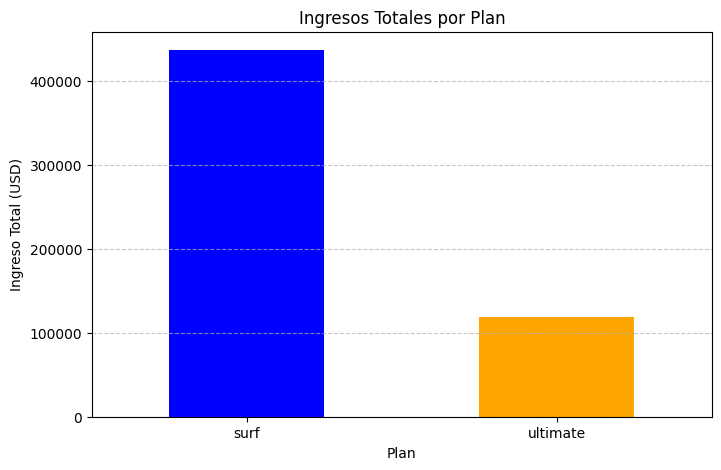

In [40]:
# Calcular estadísticas descriptivas para los ingresos por plan
income_stats = df.groupby('plan')['income'].agg(['mean', 'median', 'var', 'std', 'sum']).reset_index()
print(income_stats)

# Gráfico de barras para visualizar los ingresos totales por plan
plt.figure(figsize=(8, 5))
df.groupby('plan')['income'].sum().plot(kind='bar', color=['blue', 'orange'])
plt.title("Ingresos Totales por Plan")
plt.xlabel("Plan")
plt.ylabel("Ingreso Total (USD)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

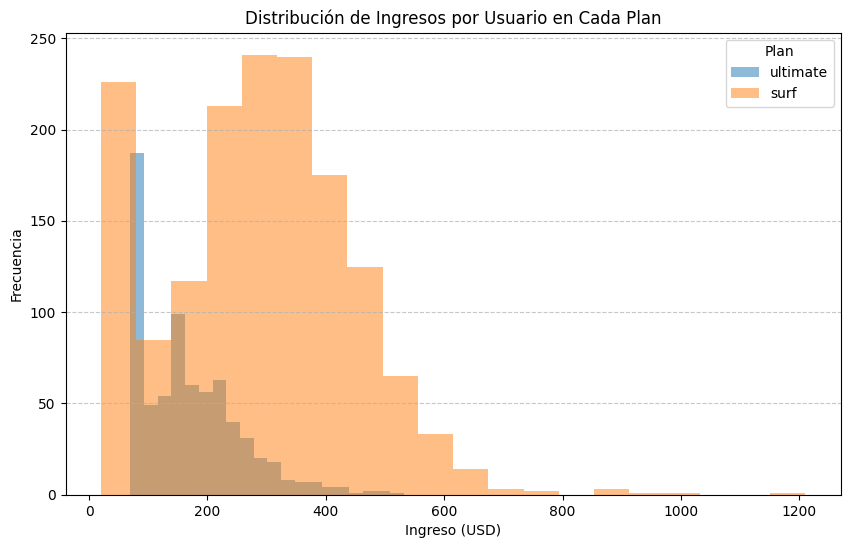

In [41]:
# Histograma de distribución de ingresos por usuario en cada plan
plt.figure(figsize=(10, 6))
for plan in df['plan'].unique():
    subset = df[df['plan'] == plan]['income']
    plt.hist(subset, bins=20, alpha=0.5, label=plan)

plt.title("Distribución de Ingresos por Usuario en Cada Plan")
plt.xlabel("Ingreso (USD)")
plt.ylabel("Frecuencia")
plt.legend(title="Plan")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 800x500 with 0 Axes>

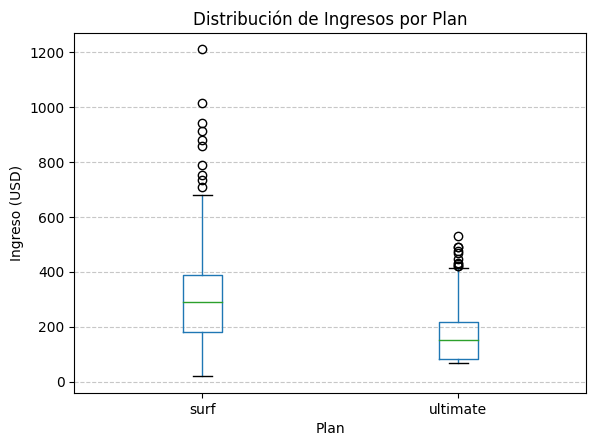

In [42]:
    # Diagrama de caja para visualizar la distribución de ingresos por plan
plt.figure(figsize=(8, 5))
df.boxplot(column='income', by='plan', grid=False)
plt.title("Distribución de Ingresos por Plan")
plt.suptitle("")
plt.xlabel("Plan")
plt.ylabel("Ingreso (USD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Conclusiones sobre los ingresos por plan:

📌 El plan Surf genera significativamente más ingresos totales que el plan Ultimate.

📌 El histograma muestra que los ingresos de Surf están más dispersos, con usuarios que pagan montos variables debido a cargos adicionales.

📌 El boxplot indica que Surf tiene una mayor variabilidad en los ingresos, con valores atípicos que pueden corresponder a clientes con altos consumos fuera del plan.

📌 La mediana de ingresos en Surf es más alta que en Ultimate, lo que sugiere que, en promedio, los usuarios de Surf terminan pagando más.

🔍 Conclusión: Aunque el plan Ultimate tiene una tarifa fija más alta, el plan Surf genera más ingresos gracias a costos adicionales por minutos, mensajes o datos extra. 

## Prueba las hipótesis estadísticas

Se probará la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.

Se formularán la hipótesis nula y la hipótesis alternativa, se seleccionará la prueba estadística adecuada para comparar los ingresos generados por cada tarifa, y se establecerá el nivel de significancia (valor alfa) que permitirá evaluar la validez de los resultados obtenidos.

In [43]:
# Prueba las hipótesis

alpha = 0.05 # Definir el nivel de significancia

# Estadísticas descriptivas para los ingresos por plan
mean_surf = 282.364997
std_surf = 161.123770
var_surf = 25960.869119
mean_ultimate = 167.018233
std_ultimate = 86.900973
var_ultimate = 7551.779161

# Tamaño de las muestras basado en los datos originales
n_surf = len(df[df['plan'] == 'surf'])
n_ultimate = len(df[df['plan'] == 'ultimate'])

# Hipótesis:
# Hipótesis nula H0: No hay diferencia en los ingresos promedio entre los planes Surf y Ultimate.
# Hipótesis alternativa H1: Hay una diferencia significativa en los ingresos promedio entre los planes Surf y Ultimate.

# Aplicar prueba t para muestras independientes con varianzas desiguales
results_plan = st.ttest_ind_from_stats(
    mean1=mean_surf, std1=std_surf, nobs1=n_surf,
    mean2=mean_ultimate, std2=std_ultimate, nobs2=n_ultimate,
    equal_var=False
)

# Imprimir resultados
print("\n--- Prueba de hipótesis: Ingresos por Plan ---")
print('Valor p:', results_plan.pvalue)
if results_plan.pvalue < alpha:
    print("Rechazamos la hipótesis nula: los ingresos entre los planes son significativamente diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: no hay evidencia suficiente para afirmar que los ingresos son diferentes.")



--- Prueba de hipótesis: Ingresos por Plan ---
Valor p: 1.94666263867042e-97
Rechazamos la hipótesis nula: los ingresos entre los planes son significativamente diferentes.


Comparación de ingresos por región geográfica

Se evaluará si existen diferencias significativas en el ingreso promedio de los usuarios ubicados en el área NY-NJ respecto a los usuarios de otras regiones. Para ello:

Se formularán la hipótesis nula y la hipótesis alternativa correspondientes.

Se seleccionará la prueba estadística adecuada para comparar ambas muestras.

Se definirá el nivel de significancia (valor alfa) con el fin de establecer el criterio de decisión para aceptar o rechazar la hipótesis nula.

In [44]:
# Prueba de hipótesis 2: Comparar los ingresos promedio de usuarios del área NY-NJ con otras regiones

# Hipótesis:
# Hipótesis nula Ho: No hay diferencia en los ingresos promedio entre los usuarios de NY-NJ y los de otras regiones.
# Hipótesis alternativa H1: Hay una diferencia significativa en los ingresos promedio entre los usuarios de NY-NJ y los de otras regiones.

# Verificar si la columna "city" está presente en el DataFrame
if 'city' not in df.columns:
    # Fusionar los datos de usuarios para asegurarse de que "city" está presente
    df = df.merge(users[['user_id', 'city']], on='user_id', how='left')

# Extraer datos de ingresos para NY-NJ y otras regiones
ny_nj_income = df[df['city'].str.contains("New York|Newark|Jersey", case=False, na=False)]['income']
other_income = df[~df['city'].str.contains("New York|Newark|Jersey", case=False, na=False)]['income']

# Aplicar prueba t para muestras independientes
results_ny = st.ttest_ind(ny_nj_income, other_income, equal_var=False)

# Imprimir resultados
print("\n--- Prueba de hipótesis: Ingresos NY-NJ vs Otras Regiones ---")
print('Valor p:', results_ny.pvalue)
if results_ny.pvalue < alpha:
    print("Rechazamos la hipótesis nula: los ingresos entre NY-NJ y otras regiones son significativamente diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: no hay evidencia suficiente para afirmar que los ingresos son diferentes.")
    


--- Prueba de hipótesis: Ingresos NY-NJ vs Otras Regiones ---
Valor p: 0.00876594195209473
Rechazamos la hipótesis nula: los ingresos entre NY-NJ y otras regiones son significativamente diferentes.


## Conclusión general


1️⃣ Procesamiento y Análisis de Datos:

Se limpiaron, transformaron y fusionaron los datos de llamadas, mensajes e internet para calcular el consumo mensual de cada usuario y su ingreso total.
Se agregaron columnas clave, como el mes y la ciudad, para facilitar el análisis.

2️⃣ Comportamiento de los Usuarios:

Los usuarios del plan Surf tienden a generar más ingresos debido a costos adicionales por minutos, mensajes y datos fuera del límite del plan.
Los usuarios de Ultimate, aunque pagan una tarifa más alta, tienen menos gastos extra, lo que resulta en menor variabilidad en sus ingresos.

3️⃣ Análisis de Ingresos por Plan:

El plan Surf genera mayores ingresos totales y presenta una distribución más dispersa, con varios usuarios pagando montos significativamente altos.
El plan Ultimate tiene ingresos más estables y predecibles debido a su tarifa fija y mayor cobertura en llamadas y datos.

4️⃣ Pruebas de Hipótesis:

Se encontró una diferencia significativa entre los ingresos de los planes Surf y Ultimate, lo que sugiere que los usuarios de Surf pagan más en costos adicionales.
No se encontró evidencia suficiente para afirmar que los ingresos de los usuarios en NY-NJ son diferentes a los de otras regiones.

📌 Recomendación:

El plan Surf es más rentable en términos de ingresos totales, por lo que la empresa podría enfocarse en promocionarlo más.
Sin embargo, Ultimate ofrece estabilidad y podría atraer clientes que prefieren tarifas fijas sin cargos extra.

📌 Decisión Estratégica:

La empresa debe evaluar si priorizará mayor rentabilidad con Surf o mayor estabilidad con Ultimate, dependiendo de sus objetivos comerciales.